# Compute Maximum Drawdown

We'll develop the code to compute the maximum drawdown of a return series, and we'll start to develop our own module which will act as a toolkit that we will add to for later.

First, let's read the return series:

<AxesSubplot:>

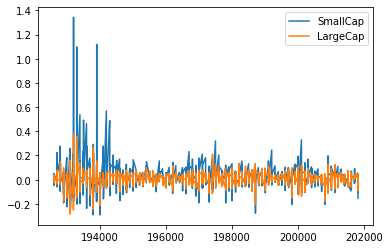

In [1]:
import pandas as pd

me_m = pd.read_csv("data/Portfolios_Formed_on_ME_monthly_EW.csv",
                   header=0, index_col=0, parse_dates=True, na_values=-99.99)
rets = me_m[['Lo 10', 'Hi 10']]
rets.columns = ['SmallCap', 'LargeCap']
rets = rets/100
rets.plot.line()

### 1. Timeseries - forcing the index to be a datetime

We asked Pandas to `parse_dates` in `read_csv()`. Let's check if it was able to do so with the index:

In [2]:
rets.index

Int64Index([192607, 192608, 192609, 192610, 192611, 192612, 192701, 192702,
            192703, 192704,
            ...
            201803, 201804, 201805, 201806, 201807, 201808, 201809, 201810,
            201811, 201812],
           dtype='int64', length=1110)

In [3]:
rets.index = pd.to_datetime(rets.index, format="%Y%m")
rets.index

DatetimeIndex(['1926-07-01', '1926-08-01', '1926-09-01', '1926-10-01',
               '1926-11-01', '1926-12-01', '1927-01-01', '1927-02-01',
               '1927-03-01', '1927-04-01',
               ...
               '2018-03-01', '2018-04-01', '2018-05-01', '2018-06-01',
               '2018-07-01', '2018-08-01', '2018-09-01', '2018-10-01',
               '2018-11-01', '2018-12-01'],
              dtype='datetime64[ns]', length=1110, freq=None)

Now that the DataFrame has a datetime index, we can treat the entire dataframe as a timeseries, which makes things very convenient. For instance, we can extract just the returns in 2008 as follows:

In [4]:
rets["2008"]

C:\Users\NGUYEN Xuan Vinh\AppData\Local\Temp\ipykernel_12272\1232546118.py:1: FutureWarning: Indexing a DataFrame with a datetimelike index using a single string to slice the rows, like `frame[string]`, is deprecated and will be removed in a future version. Use `frame.loc[string]` instead.
  rets["2008"]


,SmallCap,LargeCap
2008-01-01,-0.0436,-0.0490
2008-02-01,-0.0203,-0.0250
2008-03-01,-0.0440,-0.0122
2008-04-01,0.0027,0.0492
2008-05-01,0.0286,0.0161
2008-06-01,-0.0816,-0.1015
2008-07-01,-0.0079,-0.0140
2008-08-01,0.0110,0.0087
2008-09-01,-0.1274,-0.1155
2008-10-01,-0.2041,-0.1763


This looks good except that we know this is monthly data, and it's showing up with an index that is date stamped. We can fix this using the `to_period` method. We'll see several more examples of Pandas support for timeseries during the course.

In [6]:
rets.index = rets.index.to_period('M')
rets.head()

,SmallCap,LargeCap
1926-07,-0.0145,0.0329
1926-08,0.0512,0.0370
1926-09,0.0093,0.0067
1926-10,-0.0484,-0.0243
1926-11,-0.0078,0.0270


In [7]:
rets.info()

<class 'pandas.core.frame.DataFrame'>
PeriodIndex: 1110 entries, 1926-07 to 2018-12
Freq: M
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   SmallCap  1110 non-null   float64
 1   LargeCap  1110 non-null   float64
dtypes: float64(2)
memory usage: 26.0 KB


In [8]:
rets.describe()

,SmallCap,LargeCap
count,1110.000000,1110.000000
mean,0.017598,0.008870
std,0.106288,0.053900
min,-0.291400,-0.284300
25%,-0.027350,-0.017025
50%,0.010450,0.011400
75%,0.049950,0.037650
max,1.342900,0.377900


### 2. Computing Drawdowns

1. Convert the time series of returns to a time series that represents a wealth index
2. Compute a time series of the previous peaks
3. Compute the Drawdown as the difference between the previous peak and the current value

Let's do this for Large Cap stocks.

<AxesSubplot:>

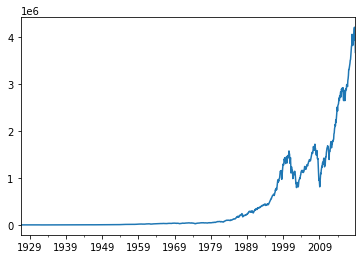

In [9]:
# start with 1000 dollars
wealth_index = 1000*(1+rets["LargeCap"]).cumprod()
wealth_index.plot()

<AxesSubplot:>

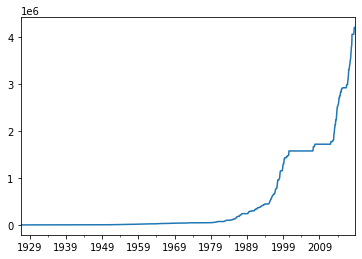

In [10]:
previous_peaks = wealth_index.cummax()
previous_peaks.plot()

<AxesSubplot:>

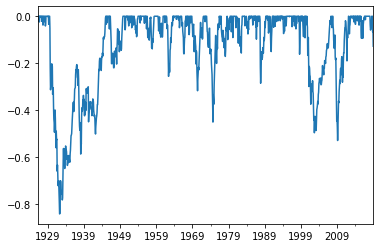

In [11]:
drawdown = (wealth_index - previous_peaks)/previous_peaks
drawdown.plot()

In [12]:
drawdown.min()

-0.8400375277943123

In [13]:
drawdown["1975":].min()

-0.5280945042309304

# Creating a Drawdown Function

Redoing this analysis for SmallCap would be tedious, since we would need to re-enter all these commands at the prompt. Instead, let's create our first function that will form the first tool in our financial toolkit.

The function will take as input, a timeseries of returns, and return a timeseries as a DataFrame that contains the wealth index, the previous peaks and the drawdowns as a percent.

In [14]:
def drawdown(return_series: pd.Series):
    """Takes a time series of asset returns.
       returns a DataFrame with columns for
       the wealth index, 
       the previous peaks, and 
       the percentage drawdown
    """
    wealth_index = 1000*(1+return_series).cumprod()
    previous_peaks = wealth_index.cummax()
    drawdowns = (wealth_index - previous_peaks)/previous_peaks
    return pd.DataFrame({"Wealth": wealth_index, 
                         "Previous Peak": previous_peaks, 
                         "Drawdown": drawdowns})

drawdown(rets["LargeCap"]).head()

,Wealth,Previous Peak,Drawdown
1926-07,1032.900000,1032.900000,0.0000
1926-08,1071.117300,1071.117300,0.0000
1926-09,1078.293786,1078.293786,0.0000
1926-10,1052.091247,1078.293786,-0.0243
1926-11,1080.497711,1080.497711,0.0000


In [15]:
drawdown(rets["LargeCap"]).min()

Wealth            405.769102
Previous Peak    1032.900000
Drawdown           -0.840038
dtype: float64

In [16]:
drawdown(rets["SmallCap"]).min()

Wealth           491.240323
Previous Peak    985.500000
Drawdown          -0.833001
dtype: float64

<AxesSubplot:>

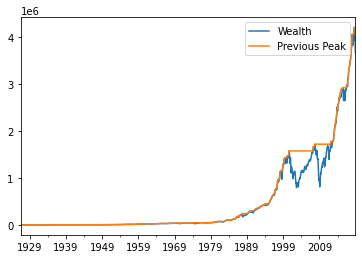

In [22]:
drawdown(rets["LargeCap"])[["Wealth", "Previous Peak"]].plot()

<AxesSubplot:>

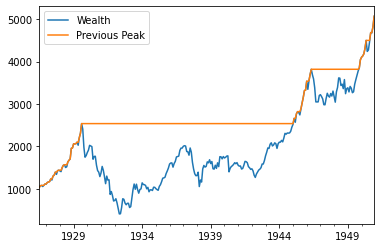

In [23]:
drawdown(rets[:"1950"]["LargeCap"])[["Wealth", "Previous Peak"]].plot()

In [17]:
drawdown(rets["LargeCap"])["Drawdown"].idxmin()

Period('1932-05', 'M')

In [18]:
drawdown(rets["SmallCap"])["Drawdown"].idxmin()

Period('1932-05', 'M')

In [19]:
drawdown(rets["LargeCap"]["1975":])["Drawdown"].idxmin()

Period('2009-02', 'M')

In [20]:
drawdown(rets["SmallCap"]["1975":])["Drawdown"].idxmin()

Period('2009-02', 'M')

In [21]:
# There a crash since 1975 and it happens in 2009-02
drawdown(rets["SmallCap"]["1975":])["Drawdown"].min()

-0.6312068077252386